In [138]:
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score
from keras import models
import matplotlib.pyplot as plt

def datapreprocessing(img): 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    dim =(32,32)
    img = cv2.resize(img,dim,cv2.INTER_AREA)
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    img = (img.astype('float32')) / 255.0
    
    return img


In [140]:
from keras.datasets import cifar10
from keras import optimizers
import numpy as np
from sklearn import preprocessing


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
interested = [0, 1, 8, 9]

scrap = []
for idx, im in enumerate(x_train):
    if (y_train[idx][0] not in interested):
        scrap.append(idx)
        
x_train = np.delete(x_train, scrap, axis=0)
y_train = np.delete(y_train, scrap, axis=0)

enc = preprocessing.OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

scrap = []
for idx, im in enumerate(x_test):
    if (y_test[idx][0] not in interested):
        scrap.append(idx)
x_test = np.delete(x_test, scrap, axis=0)
y_test = np.delete(y_test, scrap, axis=0)
y_test = enc.transform(y_test).toarray()

x_train = (x_train.astype('float32')) / 255.0
x_test = (x_test.astype('float32')) / 255.0

print(x_train.shape)
print(x_test.shape)

(20000, 32, 32, 3)
(4000, 32, 32, 3)


In [141]:
def show_image(x):
    plt.imshow(x)

In [142]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=512, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2, 2, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [143]:
encoder, decoder = build_deep_autoencoder((32,32,3), code_size=64)
encoder.summary()
decoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)        

In [25]:

inp = L.Input((32,32,3))
code = encoder(inp)
reconstruction = decoder(code)

In [26]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')


In [27]:
autoencoder.fit(x=x_train, y=x_train, epochs=5)

Epoch 1/5
625/625 [==============================] - 69s 110ms/step - loss: 0.0342
Epoch 2/5
625/625 [==============================] - 65s 104ms/step - loss: 0.0182
Epoch 3/5
625/625 [==============================] - 68s 110ms/step - loss: 0.0147
Epoch 4/5
625/625 [==============================] - 69s 110ms/step - loss: 0.0129
Epoch 5/5
625/625 [==============================] - 67s 107ms/step - loss: 0.0118


In [164]:
y_pred = autoencoder.predict(x_test)
y_pred

array([[[[0.87450576, 0.8926525 , 0.92740256],
         [0.8859974 , 0.9249801 , 0.9317179 ],
         [0.89429   , 0.91286826, 0.93814296],
         ...,
         [0.92134184, 0.9280849 , 0.922254  ],
         [0.9148168 , 0.9295964 , 0.934568  ],
         [0.9053732 , 0.92561936, 0.934841  ]],

        [[0.90072477, 0.912492  , 0.9291384 ],
         [0.9132468 , 0.93055934, 0.9332288 ],
         [0.9230465 , 0.9503726 , 0.9314993 ],
         ...,
         [0.93857914, 0.9358237 , 0.9407904 ],
         [0.9344612 , 0.9327337 , 0.94322926],
         [0.9265319 , 0.9381699 , 0.9525974 ]],

        [[0.9291085 , 0.91035104, 0.94246304],
         [0.92396563, 0.94188875, 0.9270204 ],
         [0.9409985 , 0.94278216, 0.95197743],
         ...,
         [0.9510205 , 0.94522226, 0.930851  ],
         [0.9492402 , 0.9418801 , 0.95396745],
         [0.9460225 , 0.95804656, 0.9559204 ]],

        ...,

        [[0.22248739, 0.21547729, 0.19197147],
         [0.14716011, 0.14871395, 0.1360601 ]

In [ ]:
labels = ['airplane', 'automobile', 'ship', 'truck']
lookup = np.argmax(y_test[:, :], axis=1)

In [28]:
autoencoder.save("autoencoder.h5")

In [50]:
def displayimage(image) :
    img = datapreprocessing(image)
    res = autoencoder.predict(img)
    res = np.squeeze(res,axis=0)
    plt.imshow(res)

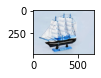

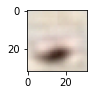

In [52]:
import cv2
query = cv2.imread("ship-1.jpg")
plt.figure(figsize=[5,5])
plt.subplot(1,4,1)
plt.imshow(query)
displayimage(query)

In [144]:
features = encoder.predict(x_train)
print(features.shape)

(20000, 64)


In [145]:

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(features)

NearestNeighbors(metric='euclidean')

In [173]:
def get_similar(image, n_neighbors=10):
    code = encoder.predict(image)
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors) 
    return distances,idx

In [147]:
import numpy as np

In [148]:
labels = ['airplane', 'automobile', 'ship', 'truck']
lookup = np.argmax(y_train[:, :], axis=1)

ship


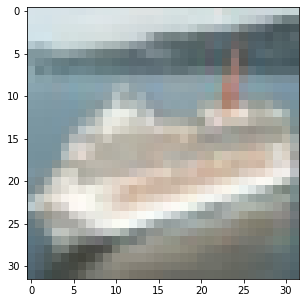

In [174]:
import random
import matplotlib.pyplot as plt


idx = random.randrange(0,20000)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))

plt.imshow(x_train[idx])
img = np.expand_dims(x_train[idx],axis=0)
distance,results = get_similar(img)
print(labels[lookup[idx]])


In [150]:
idx

3589

Search results:


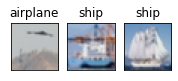

In [175]:
import matplotlib.pyplot as plt


print("Search results:")

plt.figure(figsize=(10,10))
for i in range(3):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_train[results[i+1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(str(labels[lookup[results[i+1]]]))

plt.show()

In [176]:
from sklearn.metrics import f1_score
t = np.ones(10).astype(float)
p = np.array([lookup[x] == lookup[idx] for x in results]).astype(float)

print("F1 Score for this search:", f1_score(t, p))


F1 Score for this search: 0.8235294117647058


In [153]:
def NNdisplayimage(image) :
    img = datapreprocessing(image)
    distance,results = get_similar(img)
    print("Search results:")

    plt.figure(figsize=(10,10))
    for i in range(3):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(x_train[results[i+1]])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title(str(labels[lookup[results[i+1]]]))

    plt.show()

Search results:


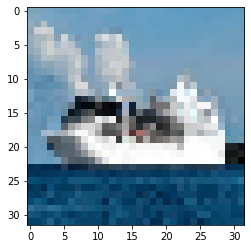

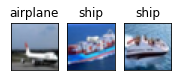

In [155]:
query = cv2.imread("ship.jfif")
NNdisplayimage(query)